## Track upwelled water using a step profile

I added two tracers, besides the original advetive tracer with linear profile, to track water upwelled through the canyon. One has a concentration of 1 below the shelf break depth and 0 above; the otherone has 0 below shelf break depth and 1 above, to track shelf water. 

These preliminary runs are under CNTDIFF_STEP. Run38 is the base case with canyon and run42 is the base case without a canyon. 

In [36]:
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg
import canyon_tools.metrics_tools as mtt 

In [2]:
sns.set_style('dark')

In [26]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

def BottomConc(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[BottomInd[i,j],i,j]
            ConcArea[i,j] = TrBottom*ra[i,j]
            Conc[i,j] = TrBottom
            Area[i,j] = ra[i,j]
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def BottomAnom(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Tracer field-Tr field no canyon (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[BottomInd[i,j],i,j]
            if TrBottom > 0.0:
                ConcArea[i,j] = TrBottom*ra[i,j]
                Conc[i,j] = TrBottom
                Area[i,j] = ra[i,j]
            else:
                ConcArea[i,j] = np.NaN
                Conc[i,j] = np.NaN
                Area[i,j] = np.NaN
                

        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def PlotPool(ax,ConcFilt,xslice,yslice,colmap, cmin=-1, cmax=1):
    
    BAC = ConcFilt[yslice,xslice]
    
    mesh = ax.contourf(X[xslice]/1000,Y[yslice]/1000,BAC,20,
                       vmin=cmin, vmax=cmax, cmap=colmap, 
                      )
    
    SB = ax.contour(X[xslice]/1000,Y[yslice]/1000,
                    Depth[yslice,xslice],
                    [152.5],
                    colors='0.1',linewidths=[0.75] )
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.set_aspect(1)
    return(mesh)

In [4]:
# Grid, state and tracers datasets of base case
grid_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF_STEP/run38/gridGlob.nc'
state_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF_STEP/run38/stateGlob.nc' 
ptracers_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF_STEP/run38/ptracersGlob.nc'

grid_fileNoC = '/data/kramosmu/results/TracerExperiments/CNTDIFF_STEP/run42/gridGlob.nc'
state_fileNoC = '/data/kramosmu/results/TracerExperiments/CNTDIFF_STEP/run42/stateGlob.nc' 
ptracers_fileNoC = '/data/kramosmu/results/TracerExperiments/CNTDIFF_STEP/run42/ptracersGlob.nc' 
# Still waiting for this run to finish on graham


In [105]:
with Dataset(grid_file, 'r') as nbl:
    Z = nbl.variables['RC'][:]
    X = nbl.variables['X'][:]
    Y = nbl.variables['Y'][:]
    hFacC = nbl.variables['HFacC'][:]
    rA = nbl.variables['rA'][:]
    Depth = nbl.variables['Depth'][:]
    drF = nbl.variables['drF'][:]
    dxF = nbl.variables['dxF'][:,:]
    dyF = nbl.variables['dyF'][:,:]

hfac = np.ma.masked_values(hFacC, 0)
maskC = np.ma.getmask(hfac)
    
with Dataset(grid_fileNoC, 'r') as nbl:
    hFacCNoC = nbl.variables['HFacC'][:]

hfacNoC = np.ma.masked_values(hFacCNoC, 0)
maskCNoC = np.ma.getmask(hfacNoC)

    
with Dataset(state_file, 'r') as nbl:
    iters = nbl.variables['iter'][:]

### Comparison of all 4 tracers at days 1, 4, 8

#### Canyon axis

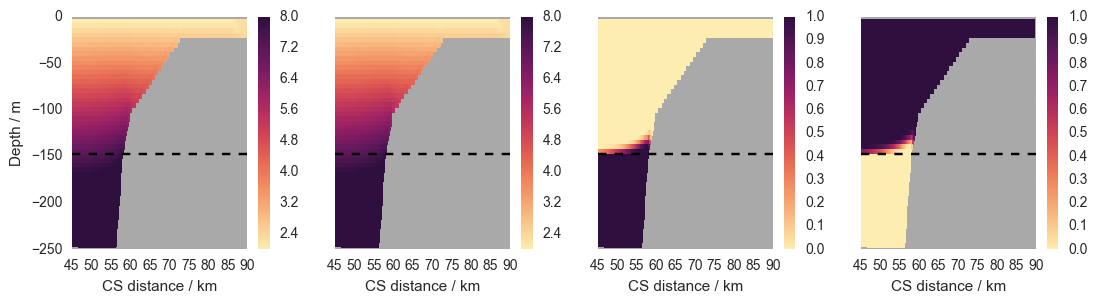

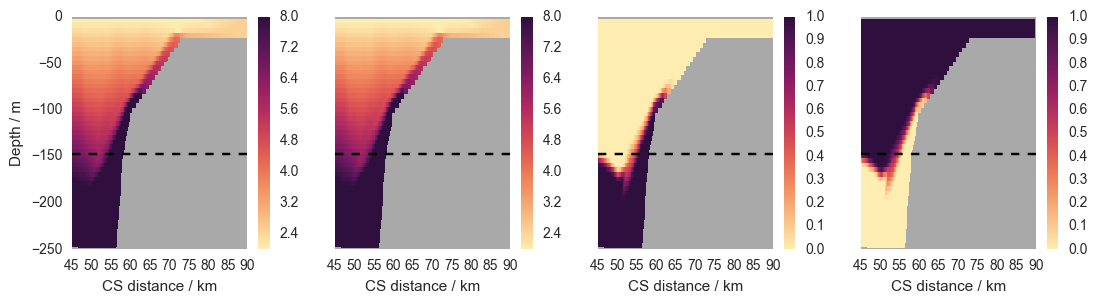

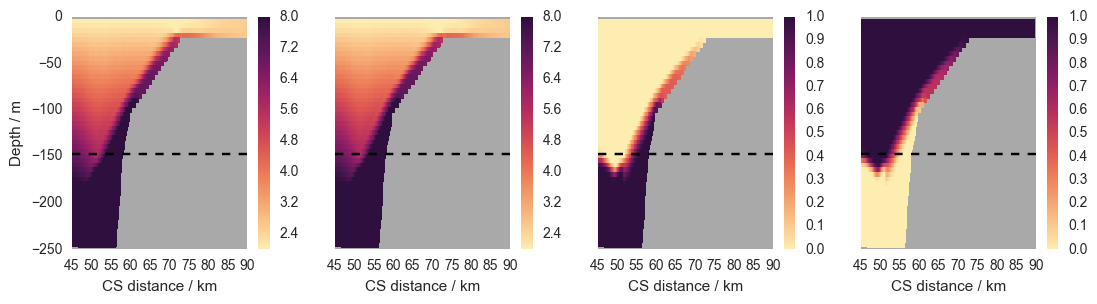

In [8]:
times = [2,8,16]
zslice = slice(0,50)
xslice = 180 # canyon axis
yslice = slice(180,360)


for tt in times:
    
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(13,3), sharey=True)
    for ax in [ax1,ax2,ax3,ax4]:
        ax.set_axis_bgcolor("darkgrey")
        ax.set_xlabel('CS distance / km')

    with Dataset(ptracers_file, 'r') as ptr:
        Tr1 = np.ma.masked_array(ptr.variables['Tr1'][tt,zslice,yslice,xslice], mask=maskC[zslice,yslice,xslice])
        Tr2 = np.ma.masked_array(ptr.variables['Tr2'][tt,zslice,yslice,xslice], mask=maskC[zslice,yslice,xslice])
        Tr3 = np.ma.masked_array(ptr.variables['Tr3'][tt,zslice,yslice,xslice], mask=maskC[zslice,yslice,xslice])
        Tr4 = np.ma.masked_array(ptr.variables['Tr4'][tt,zslice,yslice,xslice], mask=maskC[zslice,yslice,xslice])
        
    pc1 = ax1.pcolor(Y[yslice]/1000,Z[zslice],Tr1, cmap=cmo.cm.matter, vmin=2, vmax=8)
    plt.colorbar(pc1, ax=ax1)
    pc2 = ax2.pcolor(Y[yslice]/1000,Z[zslice],Tr2, cmap=cmo.cm.matter, vmin=2, vmax=8)
    plt.colorbar(pc2, ax=ax2)
    pc3 = ax3.pcolor(Y[yslice]/1000,Z[zslice],Tr3, cmap=cmo.cm.matter, vmin=0, vmax=1)
    plt.colorbar(pc3, ax=ax3)
    pc4 = ax4.pcolor(Y[yslice]/1000,Z[zslice],Tr4, cmap=cmo.cm.matter, vmin=0, vmax=1)
    plt.colorbar(pc4, ax=ax4)
    
    for ax in [ax1,ax2,ax3,ax4]:
        ax.axhline(-147.5, linestyle='--', color='k')
    
    ax1.set_ylabel('Depth / m')
    
    

#### Downstream shelf

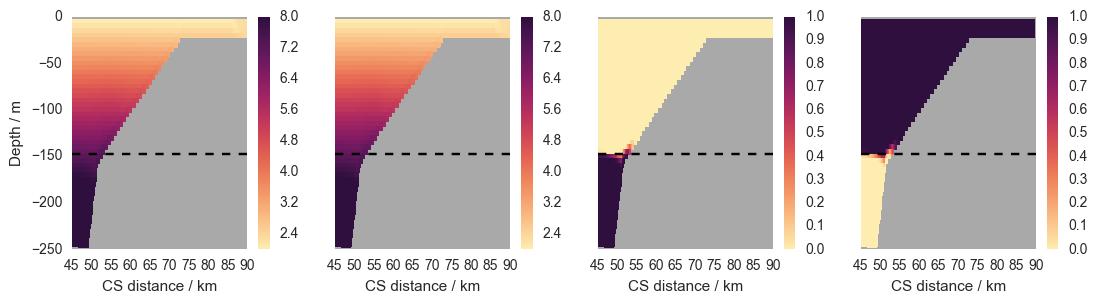

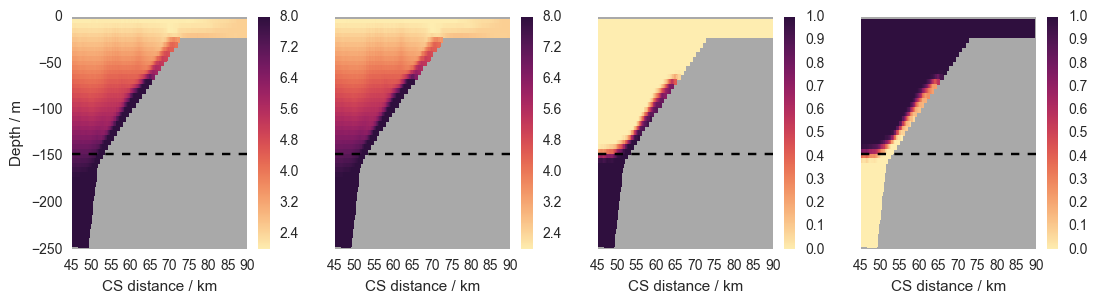

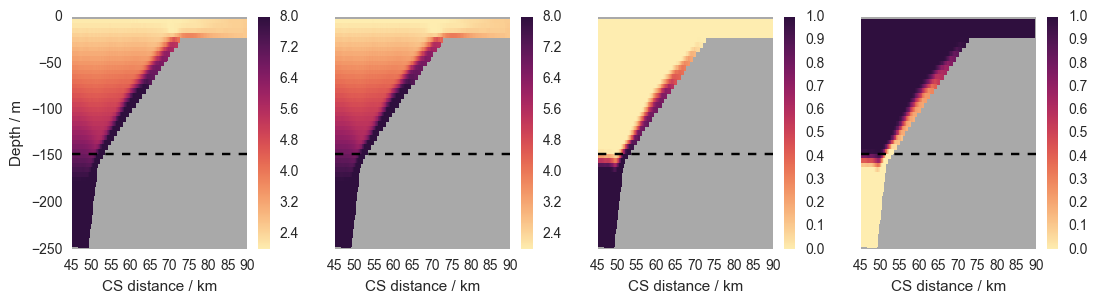

In [9]:
times = [2,8,16]
zslice = slice(0,50)
xslice = 240 # canyon axis
yslice = slice(180,360)

for tt in times:
    
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(13,3), sharey=True)
    for ax in [ax1,ax2,ax3,ax4]:
        ax.set_axis_bgcolor("darkgrey")
        ax.set_xlabel('CS distance / km')

    with Dataset(ptracers_file, 'r') as ptr:
        Tr1 = np.ma.masked_array(ptr.variables['Tr1'][tt,zslice,yslice,xslice], mask=maskC[zslice,yslice,xslice])
        Tr2 = np.ma.masked_array(ptr.variables['Tr2'][tt,zslice,yslice,xslice], mask=maskC[zslice,yslice,xslice])
        Tr3 = np.ma.masked_array(ptr.variables['Tr3'][tt,zslice,yslice,xslice], mask=maskC[zslice,yslice,xslice])
        Tr4 = np.ma.masked_array(ptr.variables['Tr4'][tt,zslice,yslice,xslice], mask=maskC[zslice,yslice,xslice])
        
    pc1 = ax1.pcolor(Y[yslice]/1000,Z[zslice],Tr1, cmap=cmo.cm.matter, vmin=2, vmax=8)
    plt.colorbar(pc1, ax=ax1)
    pc2 = ax2.pcolor(Y[yslice]/1000,Z[zslice],Tr2, cmap=cmo.cm.matter, vmin=2, vmax=8)
    plt.colorbar(pc2, ax=ax2)
    pc3 = ax3.pcolor(Y[yslice]/1000,Z[zslice],Tr3, cmap=cmo.cm.matter, vmin=0, vmax=1)
    plt.colorbar(pc3, ax=ax3)
    pc4 = ax4.pcolor(Y[yslice]/1000,Z[zslice],Tr4, cmap=cmo.cm.matter, vmin=0, vmax=1)
    plt.colorbar(pc4, ax=ax4)
    
    for ax in [ax1,ax2,ax3,ax4]:
        ax.axhline(-147.5, linestyle='--', color='k')
    
    ax1.set_ylabel('Depth / m')
    
    

### Mean bottom concentration during advective phase

In [10]:
yslice_pl = slice(225,360)
xslice_pl = slice(120,500)

with Dataset(ptracers_file, 'r') as ptr:
    ConcAreaTr1, ConcTr1, AreaTr1 = BottomConc(np.mean(ptr.variables['Tr1'][8:18,:,:,:], axis=0),hFacC,rA,Depth)
    ConcAreaTr2, ConcTr2, AreaTr2 = BottomConc(np.mean(ptr.variables['Tr2'][8:18,:,:,:], axis=0),hFacC,rA,Depth)
    ConcAreaTr3, ConcTr3, AreaTr3 = BottomConc(np.mean(ptr.variables['Tr3'][8:18,:,:,:], axis=0),hFacC,rA,Depth)
    ConcAreaTr4, ConcTr4, AreaTr4 = BottomConc(np.mean(ptr.variables['Tr4'][8:18,:,:,:], axis=0),hFacC,rA,Depth)

/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [16]:
with Dataset(ptracers_file, 'r') as ptr:
    
    with Dataset(ptracers_fileNoC, 'r') as ptr_NoC:
        
        ConcAreaTr1Anom, ConcTr1Anom, AreaTr1Anom = BottomConc(np.mean(ptr.variables['Tr1'][8:18,:,:,:]-
                                                                       ptr_NoC.variables['Tr1'][8:18,:,:,:], axis=0),
                                                               hFacCNoC,rA,Depth)
        ConcAreaTr2Anom, ConcTr2Anom, AreaTr2Anom = BottomConc(np.mean(ptr.variables['Tr2'][8:18,:,:,:]-
                                                                       ptr_NoC.variables['Tr2'][8:18,:,:,:], axis=0),
                                                               hFacCNoC,rA,Depth)
        ConcAreaTr3Anom, ConcTr3Anom, AreaTr3Anom = BottomConc(np.mean(ptr.variables['Tr3'][8:18,:,:,:]-
                                                                       ptr_NoC.variables['Tr3'][8:18,:,:,:], axis=0),
                                                               hFacCNoC,rA,Depth)
        ConcAreaTr4Anom, ConcTr4Anom, AreaTr4Anom = BottomConc(np.mean(ptr.variables['Tr4'][8:18,:,:,:]-
                                                                       ptr_NoC.variables['Tr4'][8:18,:,:,:], axis=0),
                                                               hFacCNoC,rA,Depth)
       

/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


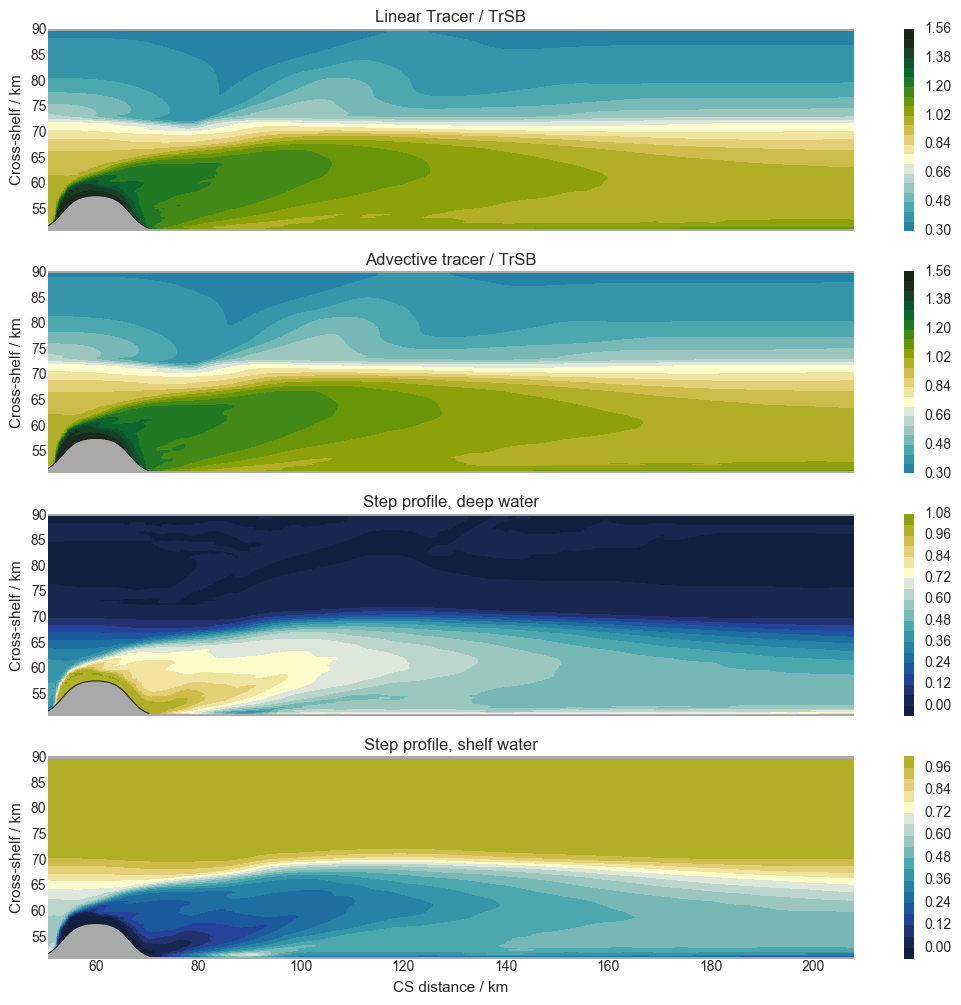

In [28]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(13,12), sharey=True, sharex = True)

mesh1 = PlotPool(ax1,ConcTr1/7.21,xslice_pl,yslice_pl, cmo.cm.delta, cmin=0, cmax=1.5)
mesh2 = PlotPool(ax2,ConcTr2/7.21,xslice_pl,yslice_pl, cmo.cm.delta, cmin=0, cmax=1.5)
mesh3 = PlotPool(ax3,ConcTr3,xslice_pl,yslice_pl, cmo.cm.delta, cmin=0, cmax=1.5)
mesh4 = PlotPool(ax4,ConcTr4,xslice_pl,yslice_pl, cmo.cm.delta, cmin=0, cmax=1.5)

plt.colorbar(mesh1, ax=ax1)
plt.colorbar(mesh2, ax=ax2)
plt.colorbar(mesh3, ax=ax3)
plt.colorbar(mesh4, ax=ax4)

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_axis_bgcolor("darkgrey")
    ax.set_ylabel('Cross-shelf / km')

ax4.set_xlabel('CS distance / km')
ax1.set_title('Linear Tracer / TrSB')
ax2.set_title('Advective tracer / TrSB')
ax3.set_title('Step profile, deep water')
ax4.set_title('Step profile, shelf water')

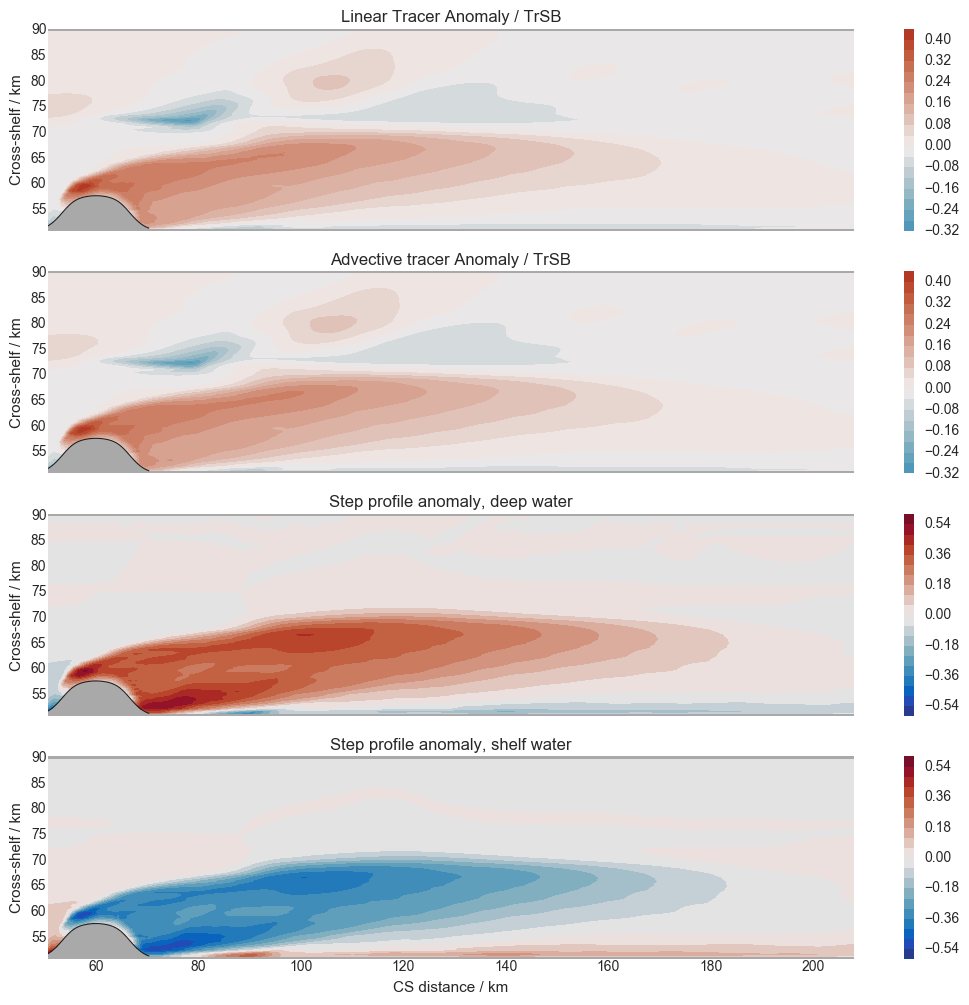

In [29]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(13,12), sharey=True, sharex = True)

mesh1 = PlotPool(ax1,ConcTr1Anom/7.21,xslice_pl,yslice_pl, cmo.cm.balance, cmin=-0.7, cmax=0.7)
mesh2 = PlotPool(ax2,ConcTr2Anom/7.21,xslice_pl,yslice_pl, cmo.cm.balance, cmin=-0.7, cmax=0.7)
mesh3 = PlotPool(ax3,ConcTr3Anom,xslice_pl,yslice_pl, cmo.cm.balance, cmin=-0.7, cmax=0.7)
mesh4 = PlotPool(ax4,ConcTr4Anom,xslice_pl,yslice_pl, cmo.cm.balance, cmin=-0.7, cmax=0.7)

plt.colorbar(mesh1, ax=ax1)
plt.colorbar(mesh2, ax=ax2)
plt.colorbar(mesh3, ax=ax3)
plt.colorbar(mesh4, ax=ax4)

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_axis_bgcolor("darkgrey")
    ax.set_ylabel('Cross-shelf / km')

ax4.set_xlabel('CS distance / km')
ax1.set_title('Linear Tracer Anomaly / TrSB')
ax2.set_title('Advective tracer Anomaly / TrSB')
ax3.set_title('Step profile anomaly, deep water')
ax4.set_title('Step profile anomaly, shelf water')

### Tracking water 

In [65]:
def calc_HCW(Tr,MaskC,rA,hFacC,drF,nzlim=29,xi=180,yi=50):
    ''' Calculate HCW for linear profiles'''
    
    maskExp = mtt.maskExpand(MaskC,Tr)
    TrMask = np.ma.array(Tr,mask=maskExp)   
    trlim = Tr[0,nzlim,yi,xi]
    
    print('tracer limit concentration is: ',trlim)
      
    # mask cells with tracer concentration < trlim on shelf
    HighConc_Masked = np.ma.masked_less(TrMask[:,:,:,:], trlim) 
    HighConc_Mask = HighConc_Masked.mask
    
    #Get volume of water of cells with relatively high concentration
    rA_exp = np.expand_dims(rA[:,:],0)
    drF_exp = np.expand_dims(np.expand_dims(drF[:],1),1)
    rA_exp = rA_exp + np.zeros(hFacC[:,:,:].shape)
    drF_exp = drF_exp + np.zeros(hFacC[:,:,:].shape)
    
    ShelfVolume = hFacC[:,:,:]*drF_exp*rA_exp
    ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
    ShelfVolume_exp = ShelfVolume_exp + np.zeros(HighConc_Mask.shape)
    
    HighConc_CellVol = np.ma.masked_array(ShelfVolume_exp,mask = HighConc_Mask) 
    VolWaterHighConc = np.zeros(np.shape(Tr)[0])+np.ma.sum(np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1),axis=1)
    VolWaterHighConc_along = np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1)
    VolWaterHighConc_across = np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=2)
    
    return (VolWaterHighConc,VolWaterHighConc_along,VolWaterHighConc_across)
 
def calc_HCW_step(Tr,MaskC,rA,hFacC,drF):
    ''' Calculate HCW for step profile'''
    
    maskExp = mtt.maskExpand(MaskC,Tr)
    TrMask = np.ma.array(Tr,mask=maskExp)   
        
    #Get fraction of volume of upwelled water
    rA_exp = np.expand_dims(rA[:,:],0)
    drF_exp = np.expand_dims(np.expand_dims(drF[:],1),1)
    rA_exp = rA_exp + np.zeros(hFacC[:,:,:].shape)
    drF_exp = drF_exp + np.zeros(hFacC[:,:,:].shape)
    
    ShelfVolume = hFacC[:,:,:]*drF_exp*rA_exp
    ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
    ShelfVolume_exp = ShelfVolume_exp + np.zeros(maskExp.shape)
    
    HighConc_CellVol = ShelfVolume_exp*TrMask
    VolWaterHighConc = np.zeros(np.shape(Tr)[0])+np.ma.sum(np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1),axis=1)
    VolWaterHighConc_along = np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1)
    VolWaterHighConc_across = np.ma.sum(np.ma.sum(HighConc_CellVol*TrMask,axis = 1),axis=2)
    
    return (VolWaterHighConc,VolWaterHighConc_along,VolWaterHighConc_across)
 
 

In [66]:
with Dataset(ptracers_file, 'r') as ptr:
    HCW1, HCW_AS1, HCW_CS1 = calc_HCW(ptr.variables['Tr1'][:,0:30,227:,:],maskCNoC[:30,227:,:],
                                      rA[227:,:],hFacCNoC[:30,227:,:],drF[:30],xi=180,yi=3)
    HCW2, HCW_AS2, HCW_CS2 = calc_HCW(ptr.variables['Tr2'][:,0:30,227:,:],maskCNoC[:30,227:,:],
                                      rA[227:,:],hFacCNoC[:30,227:,:],drF[:30],xi=180,yi=3)
    HCW3, HCW_AS3, HCW_CS3 = calc_HCW_step(ptr.variables['Tr3'][:,0:30,227:,:],maskCNoC[:30,227:,:],
                                           rA[227:,:],hFacCNoC[:30,227:,:],drF[:30])
    HCW4, HCW_AS4, HCW_CS4 = calc_HCW_step(ptr.variables['Tr4'][:,0:30,227:,:],maskCNoC[:30,227:,:],
                                           rA[227:,:],hFacCNoC[:30,227:,:],drF[:30])
  

tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757


In [67]:
with Dataset(ptracers_fileNoC, 'r') as ptr:
    HCW1NoC, HCW_AS1NoC, HCW_CS1NoC = calc_HCW(ptr.variables['Tr1'][:,0:30,227:,:],maskCNoC[:30,227:,:],
                                               rA[227:,:],hFacCNoC[:30,227:,:],drF[:30],xi=180,yi=0)
    HCW2NoC, HCW_AS2NoC, HCW_CS2NoC = calc_HCW(ptr.variables['Tr2'][:,0:30,227:,:],maskCNoC[:30,227:,:],
                                               rA[227:,:],hFacCNoC[:30,227:,:],drF[:30],xi=180,yi=0)
    HCW3NoC, HCW_AS3NoC, HCW_CS3NoC = calc_HCW_step(ptr.variables['Tr3'][:,0:30,227:,:],maskCNoC[:30,227:,:],
                                                    rA[227:,:],hFacCNoC[:30,227:,:],drF[:30])
    HCW4NoC, HCW_AS4NoC, HCW_CS4NoC = calc_HCW_step(ptr.variables['Tr4'][:,0:30,227:,:],maskCNoC[:30,227:,:],
                                                    rA[227:,:],hFacCNoC[:30,227:,:],drF[:30])


tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757


(0, 40000000000.0)

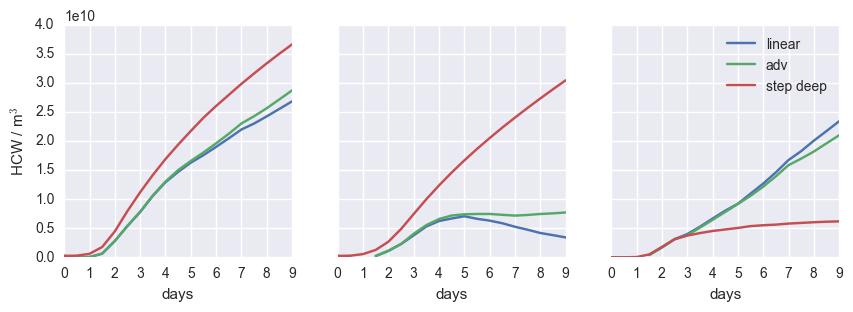

In [68]:
sns.set_style('darkgrid')

HCWs_canyon = [HCW1, HCW2, HCW3]
HCWs_NoC = [HCW1NoC, HCW2NoC, HCW3NoC]
labels = ['linear','adv','step deep', 'step shelf']

fig, ax = plt.subplots(1,3,figsize=(10,3), sharey=True)

for HCW, HCWNoC, lab in zip(HCWs_canyon, HCWs_NoC, labels):
    ax[0].plot(np.arange(19)/2, HCW, label=lab)
    ax[1].plot(np.arange(19)/2, HCWNoC, label=lab)
    ax[2].plot(np.arange(19)/2, HCW-HCWNoC, label=lab)

ax[2].legend(loc=0)
ax[0].set_ylabel('HCW / m$^3$')
ax[0].set_xlabel('days')
ax[1].set_xlabel('days')
ax[2].set_xlabel('days')
ax[0].set_ylim(0,4E10)

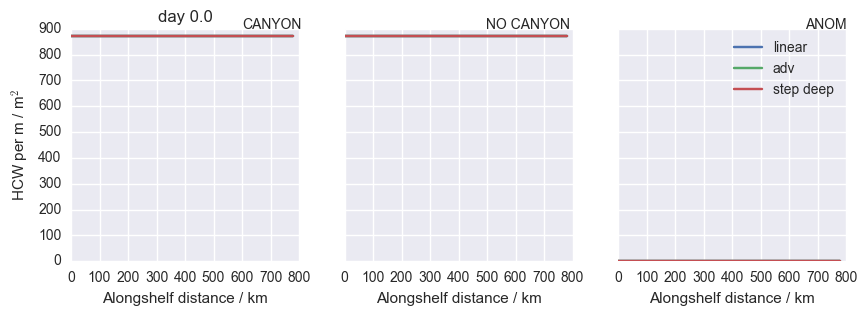

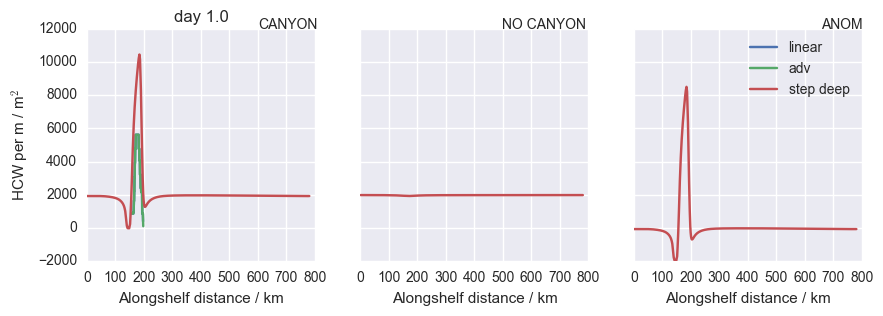

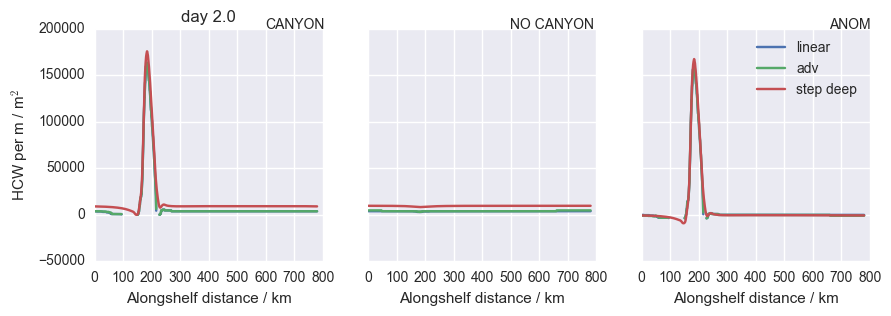

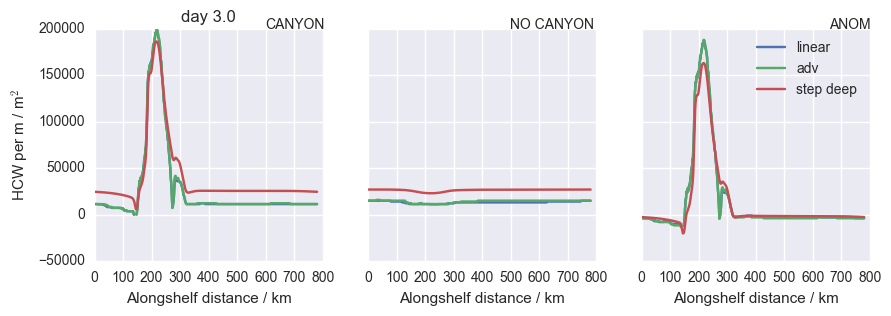

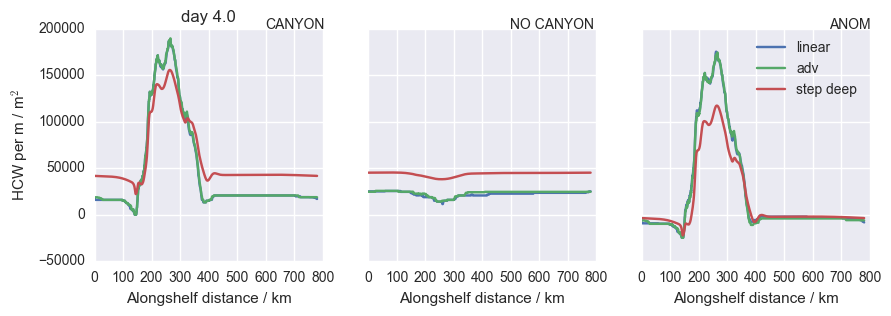

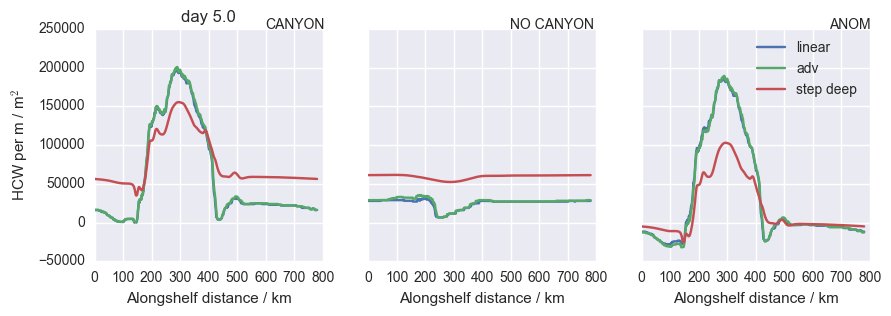

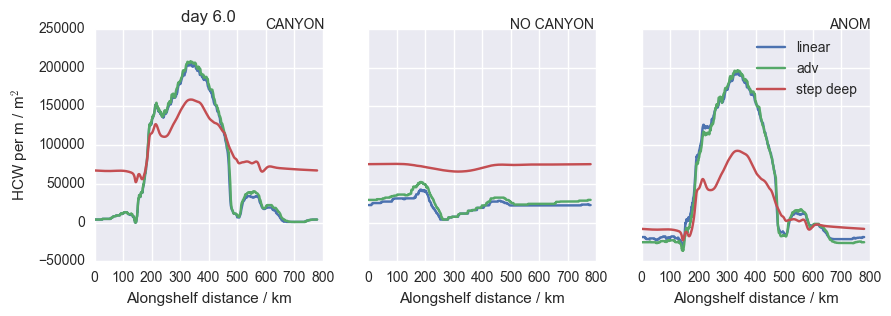

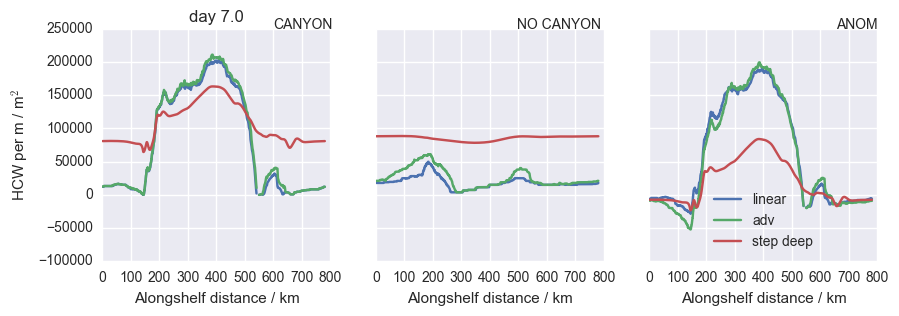

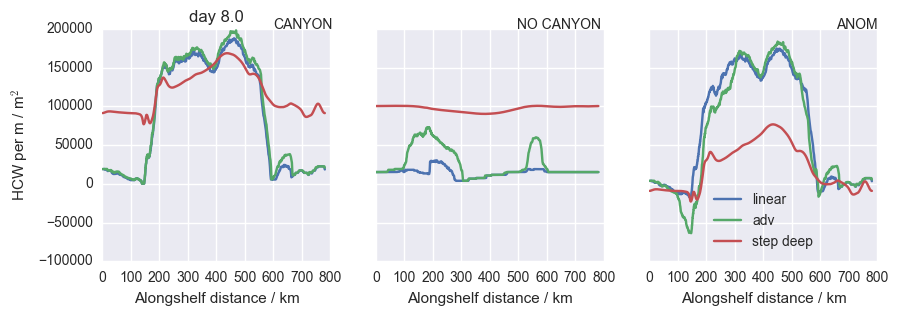

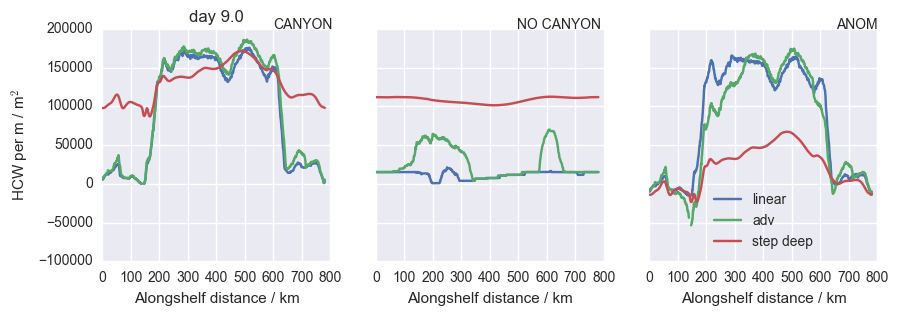

In [107]:
HCWs_canyon = [HCW_AS1, HCW_AS2, HCW_AS3]
HCWs_NoC = [HCW_AS1NoC, HCW_AS2NoC, HCW_AS3NoC]
labels = ['linear','adv','step deep', 'step shelf']

times = [0,2,4,6,8,10,12,14,16,18]


for tt in times:
    fig, ax = plt.subplots(1,3,figsize=(10,3), sharey=True)
    for HCW, HCWNoC, lab in zip(HCWs_canyon, HCWs_NoC, labels):
        ax[0].plot(X/360, HCW[tt,:]/dxF[0,:], label=lab)
        ax[1].plot(X/360, HCWNoC[tt,:]/dxF[0,:], label=lab)
        ax[2].plot(X/360, (HCW[tt,:]-HCWNoC[tt,:])/dxF[0,:], label=lab)
    
    ax[0].text(0.75,1,'CANYON',transform=ax[0].transAxes)
    ax[1].text(0.62,1,'NO CANYON',transform=ax[1].transAxes)
    ax[2].text(0.82,1,'ANOM',transform=ax[2].transAxes)
    ax[0].set_title('day %1.1f' %(tt/2))
    ax[2].legend(loc=0)
    ax[0].set_ylabel(r'HCW per m / m$^2$')
    ax[0].set_xlabel(r'Alongshelf distance / km')
    ax[1].set_xlabel(r'Alongshelf distance / km')
    ax[2].set_xlabel(r'Alongshelf distance / km')
    



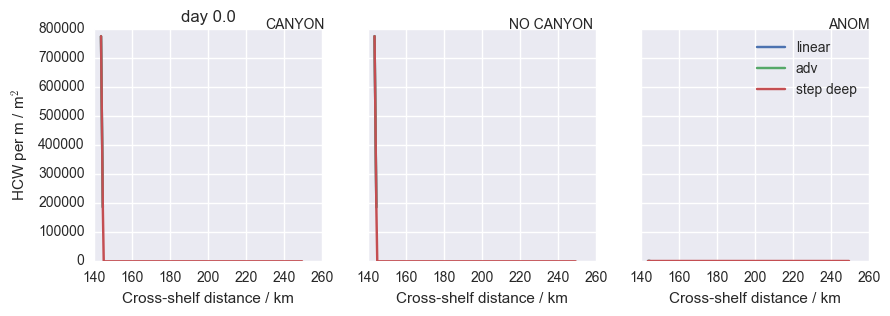

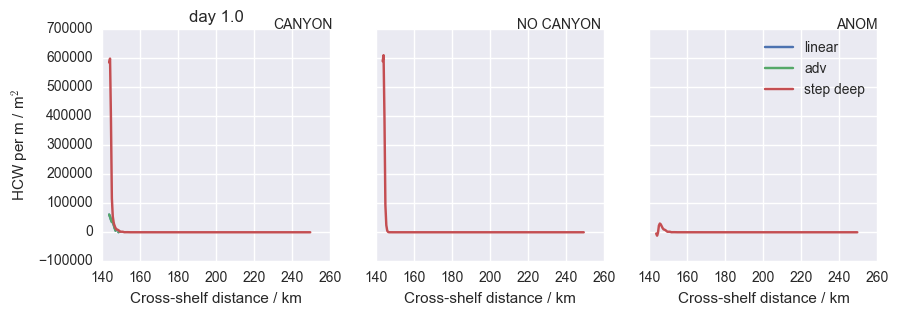

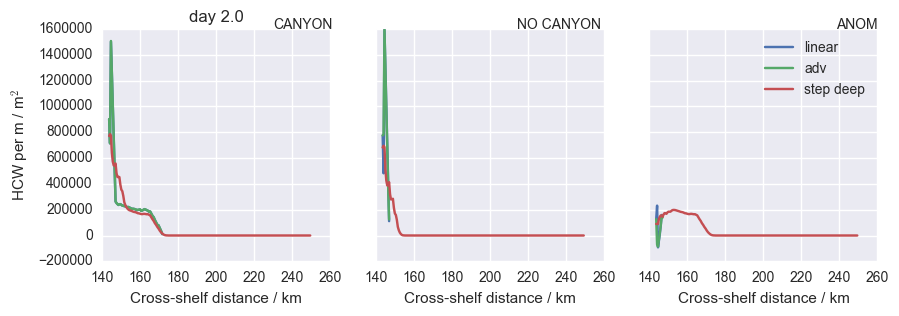

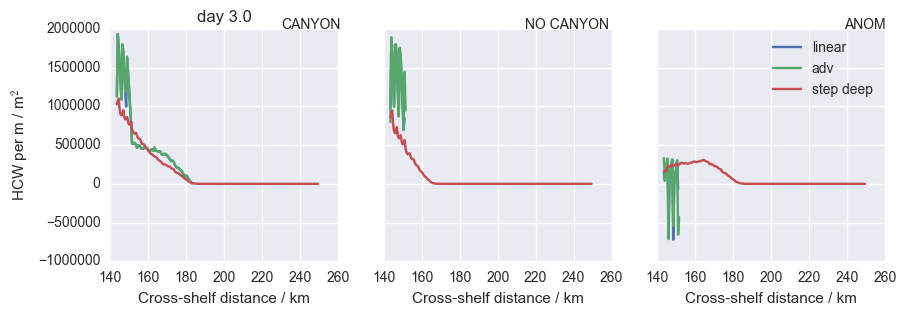

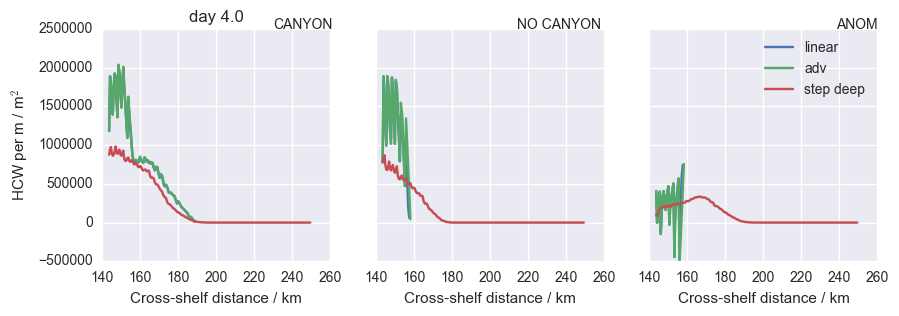

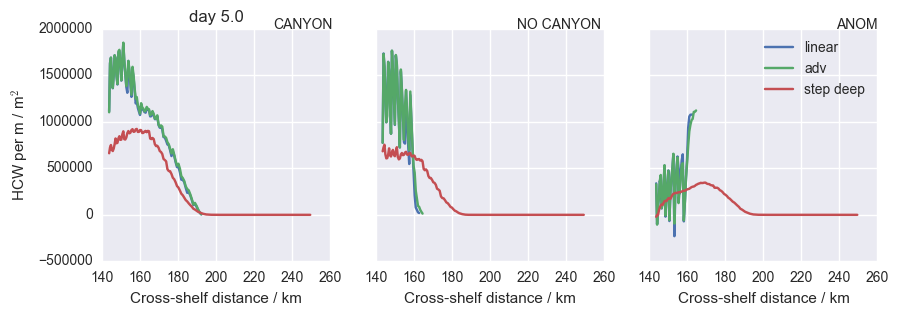

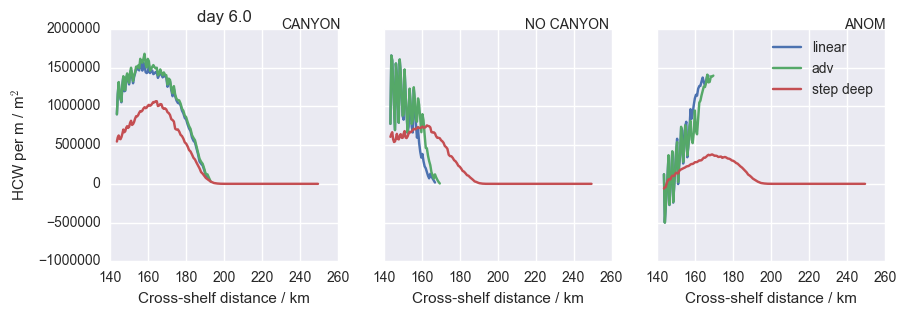

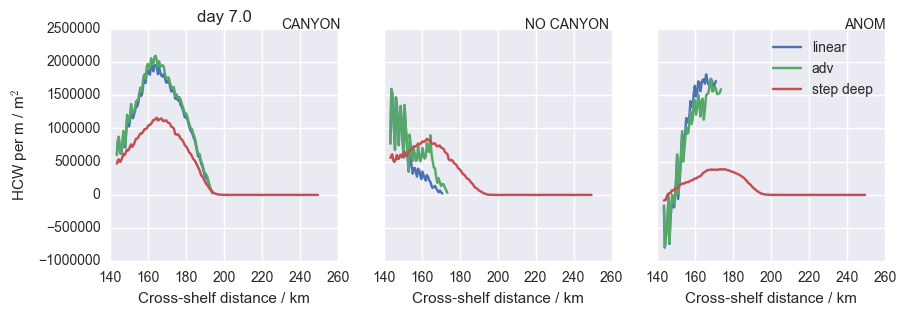

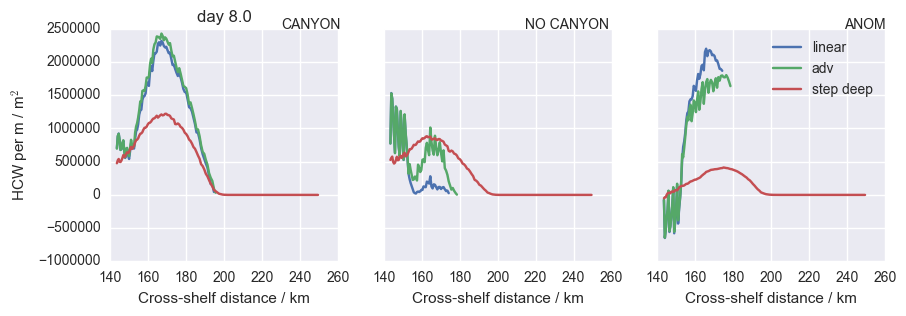

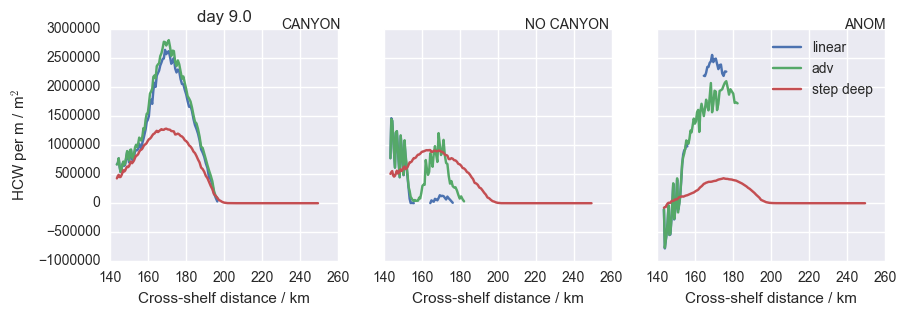

In [108]:
HCWs_canyon = [HCW_CS1, HCW_CS2, HCW_CS3]
HCWs_NoC = [HCW_CS1NoC, HCW_CS2NoC, HCW_CS3NoC]
labels = ['linear','adv','step deep', 'step shelf']

times = [0,2,4,6,8,10,12,14,16,18]


for tt in times:
    fig, ax = plt.subplots(1,3,figsize=(10,3), sharey=True)
    for HCW, HCWNoC, lab in zip(HCWs_canyon, HCWs_NoC, labels):
        ax[0].plot(Y[227:]/360, HCW[tt,:]/dyF[227:,0], label=lab)
        ax[1].plot(Y[227:]/360, HCWNoC[tt,:]/dyF[227:,0], label=lab)
        ax[2].plot(Y[227:]/360, (HCW[tt,:]-HCWNoC[tt,:])/dyF[227:,0], label=lab)
    
    ax[0].text(0.75,1,'CANYON',transform=ax[0].transAxes)
    ax[1].text(0.62,1,'NO CANYON',transform=ax[1].transAxes)
    ax[2].text(0.82,1,'ANOM',transform=ax[2].transAxes)
    ax[0].set_title('day %1.1f' %(tt/2))
    ax[2].legend(loc=0)
    ax[0].set_ylabel(r'HCW per m / m$^2$')
    ax[0].set_xlabel(r'Cross-shelf distance / km')
    ax[1].set_xlabel(r'Cross-shelf distance / km')
    ax[2].set_xlabel(r'Cross-shelf distance / km')
    